In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest



In [5]:

# Load dataset
df = pd.read_csv(r"D:\EDA2\adult_with_headers.csv")


# Basic Exploration
print(df.info())
print(df.describe(include='all'))
print(df.isnull().sum())

# Replace '?' with NaN
df.replace(' ?', np.nan, inplace=True)

# Handle missing values by dropping rows with NaN
df.dropna(inplace=True)

# Identify numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None
                 age workclass        fnlwgt education  education_num  \
count   32561.0

In [6]:
# Standard Scaling
standard_scaler = StandardScaler()
df_standard_scaled = df.copy()
df_standard_scaled[numeric_cols] = standard_scaler.fit_transform(df[numeric_cols])

# Min-Max Scaling
minmax_scaler = MinMaxScaler()
df_minmax_scaled = df.copy()
df_minmax_scaled[numeric_cols] = minmax_scaler.fit_transform(df[numeric_cols])


In [7]:
# Separate categorical columns
categorical_cols = df.select_dtypes(include='object').columns

# One-Hot Encoding for < 5 categories
df_encoded = df.copy()
for col in categorical_cols:
    if df[col].nunique() < 5:
        df_encoded = pd.get_dummies(df_encoded, columns=[col], drop_first=True)
    else:
        # Label Encoding
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df[col])


In [8]:
# Feature Engineering
# Feature 1: Age buckets
df_encoded['age_bucket'] = pd.cut(df_encoded['age'], bins=[0, 25, 45, 65, 100],
                                  labels=['young', 'adult', 'mid_age', 'senior'])


In [9]:
# Feature 2: Education efficiency = hours per week / education num
df_encoded['edu_efficiency'] = df_encoded['hours_per_week'] / df_encoded['education_num']


In [10]:
# Log transform skewed feature: capital_gain
df_encoded['capital_gain_log'] = np.log1p(df_encoded['capital_gain'])


In [11]:
# 4. Feature Selection
# Isolation Forest for outlier removal
iso = IsolationForest(contamination=0.01, random_state=42)
outlier_pred = iso.fit_predict(df_encoded.select_dtypes(include=['int64', 'float64']))
df_clean = df_encoded[outlier_pred == 1]

In [13]:
# PPS matrix
import ppscore as pyppscore
pps_matrix = df_clean.select_dtypes(include=['int64', 'float64']).columns
pps_results = pd.DataFrame(index=pps_matrix, columns=pps_matrix)
for col1 in pps_matrix:
    for col2 in pps_matrix:
        pps_results.loc[col1, col2] = pyppscore.score(df_clean, col1, col2)['ppscore']
print("PPS Matrix:")
print(pps_results.astype(float))

C:\Users\Sachin\AppData\Local\Programs\Python\Python311\Lib\site-packages\ppscore\__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


PPS Matrix:
                       age  fnlwgt  education_num  capital_gain  capital_loss  \
age               1.000000     0.0       0.000000      0.000000           0.0   
fnlwgt            0.000000     1.0       0.000000      0.000000           0.0   
education_num     0.014470     0.0       1.000000      0.000000           0.0   
capital_gain      0.002161     0.0       0.008205      1.000000           0.0   
capital_loss      0.000000     0.0       0.000000      0.000000           1.0   
hours_per_week    0.000203     0.0       0.000000      0.000000           0.0   
edu_efficiency    0.000000     0.0       0.680539      0.000000           0.0   
capital_gain_log  0.002469     0.0       0.008200      0.999042           0.0   

                  hours_per_week  edu_efficiency  capital_gain_log  
age                     0.000000        0.000000          0.000000  
fnlwgt                  0.000000        0.000000          0.000000  
education_num           0.000000        0.372758   

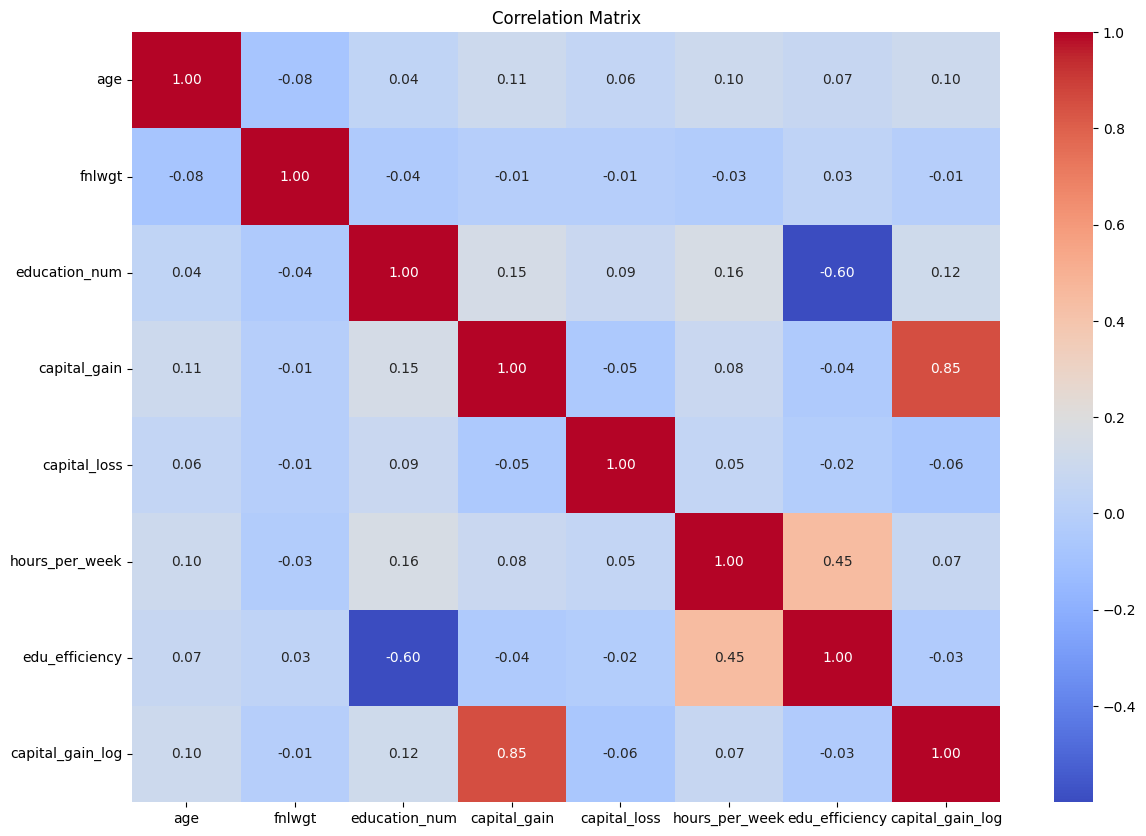

In [15]:
# Make sure seaborn is imported, usually as sns
import seaborn as sns
import matplotlib.pyplot as plt

# Select all numeric columns from the DataFrame
pps_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns

# Now, your existing code will work
plt.figure(figsize=(14, 10))
sns.heatmap(df_clean[pps_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()
